Inicia o modelo

# Emotion detector

This notebook uses [emonet](https://github.com/face-analysis/emonet) model to detect the reaction of the person in recorded videos

In [ ]:
import numpy as np
from pathlib import Path

from PIL import Image
import cv2 as cv
from matplotlib import pyplot as plt

import torch
from torchvision import transforms 
from torch.autograd import Variable

from emonet.models import EmoNet

## Step 1: Extract the emotion

- Prepares the emonet model
- Runs the model on the video

In [1]:
# Load the model (reference: https://github.com/face-analysis/emonet/blob/master/test.py)

torch.backends.cudnn.benchmark =  True

# Parameters of the experiments
n_expression = 8
device = 'cuda:0'
image_size = 256

# Loading the model 
state_dict_path = Path().cwd().parent.joinpath('pretrained', f'emonet_{n_expression}.pth')
state_dict_path = "C:/Users/eltsu/Documents/GitHub/emonet/pretrained/emonet_8.pth"

print(f'Loading the model from {state_dict_path}.')
state_dict = torch.load(str(state_dict_path), map_location='cpu')
state_dict = {k.replace('module.',''):v for k,v in state_dict.items()}
net = EmoNet(n_expression=n_expression).to(device)
net.load_state_dict(state_dict, strict=False)
net.eval()

test_transforms = transforms.Compose([transforms.Resize((256,256)),
                                      transforms.ToTensor(),
                                     ])


Loading the model from C:/Users/eltsu/Documents/GitHub/emonet/pretrained/emonet_8.pth.


In [37]:
# Extract the emotion data from the video
cap = cv.VideoCapture('Gravação - Participante 1.mp4')

crop = True

crop_size = [[270,450],[970,1280]]

freqMedia = 0
nFreq = 0

valenceHist = []
timeHist = []
expressionHist = []
arousalHist = []

while cap.isOpened():
    
    
    ret, frame = cap.read()

    if not ret:
        print("Video end")
        break

    if crop:
        frame = frame[crop_size[0][0]:crop_size[0][1], crop_size[1][0]:crop_size[1][1]]

    frameRGB = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    image = Image.fromarray(frameRGB)
    
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze(0)
    
    imgInput = Variable(image_tensor)
    imgInput = imgInput.to(device)


    e1 = cv.getTickCount()

    output = net(imgInput)

    e2 = cv.getTickCount()
    time = (e2 - e1)/ cv.getTickFrequency()
    freqMedia += 1/time
    nFreq += 1

    expression = {0: 'neutral', 1:'happy', 2:'sad', 3:'surprise', 4:'fear', 5:'disgust', 6:'anger', 7:'contempt', 8:'none'}
    expr = output['expression']
    expr = np.argmax(np.squeeze(expr.cpu().detach().numpy()), axis=0)
    expr = expression[expr]

    val = output['valence']
    val = val.cpu().detach().numpy()
    val = val[0]
    
    aro = output['arousal']
    aro = aro.cpu().detach().numpy()
    aro = aro[0]

    heatmap = output['heatmap']
    heatmap = heatmap.cpu().detach().numpy()


    valenceHist.append(val)
    timeHist.append(cap.get(cv.CAP_PROP_POS_MSEC)/1000)
    expressionHist.append(expr)
    arousalHist.append(aro)
    
    
    font = cv.FONT_HERSHEY_SIMPLEX
    cv.putText(frame, expr, (0,256), font, 1, (255,255,255), 2, cv.LINE_AA)

    #Decomment to show the result while running
    #cv.imshow('emotionDetector', frame) 
    
    #if cv.waitKey(1) == ord('q'):
    #    break

print("Frequência média: ", freqMedia/nFreq)

cap.release()
cv.destroyAllWindows()


Video end
Frequência média:  58.292055455327144


# Step 2: Data export

- Plots the detected emotion and save as a image
- Save the data as a csv file

In [7]:
# Plots arousal data
%matplotlib
plt.plot(timeHist, arousalHist, linewidth=0.5)
plt.legend(["Arousal"])
plt.title("Excitação")
plt.savefig("OneManBand-Seq1-Excitação.png",facecolor='white', transparent=False)

Using matplotlib backend: Qt5Agg


Using matplotlib backend: Qt5Agg


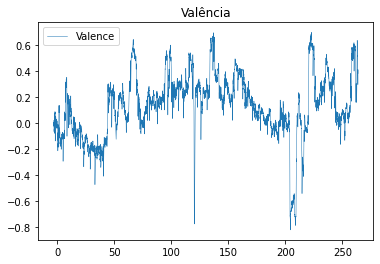

In [147]:
# Plots valence data
%matplotlib
plt.plot(timeHist, valenceHist, linewidth=0.5)
plt.legend(["Valence"])
plt.title("Valência")
plt.savefig("OneManBand-Seq1-Valência.png",facecolor='white', transparent=False)

In [6]:
#Exports to CSV
import csv

with open('OneManBand-Seq2.csv', mode='w', newline='') as file:
    writer = csv.writer(file, delimiter=';')
    
    for i in range(len(timeHist)):
        writer.writerow([timeHist[i], valenceHist[i], arousalHist[i], expressionHist[i]])